# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [5]:
pip install spacy

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: you may need to restart the kernel to use updated packages.


In [1]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')



C:\Users\jackt\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
C:\Users\jackt\anaconda3\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [2]:
# add any additional libaries you need here

import matplotlib.pyplot as plt


C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
import nltk
nltk.download('brown')

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\jackt\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
import matplotlib.pyplot as plt

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='category'>

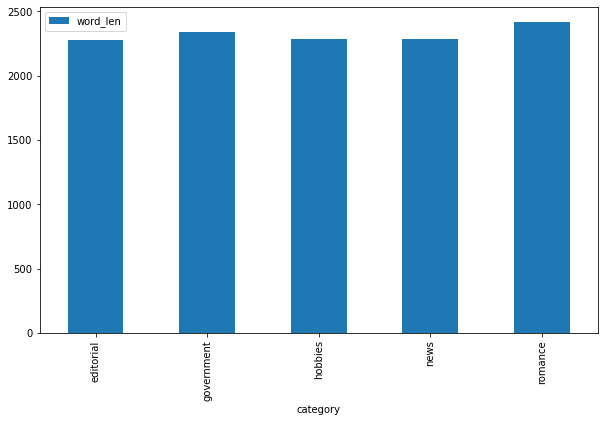

In [9]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [10]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\jackt\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(166, 4941)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: It looks like both of the dataframes contain the same dimensions (166, 4941).

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [12]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

In [14]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([18.17705433, 25.86545606, 29.54609649, 14.40020472, 12.0111884 ])

In [15]:
df['NMF_topics'] = pd.DataFrame(W_text_matrix).idxmax(axis=1)
grp_df = df.groupby(['NMF_topics','category'])['id'].count()
grp_df.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NMF_topics  category  
0           editorial     62.500000
            government    12.500000
            news          25.000000
1           editorial      9.756098
            hobbies       19.512195
            romance       70.731707
2           editorial      3.076923
            government    40.000000
            hobbies       40.000000
            news          16.923077
3           hobbies        5.555556
            news          94.444444
4           editorial     10.000000
            hobbies       10.000000
            news          80.000000
Name: id, dtype: float64

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='NMF_topics,category'>

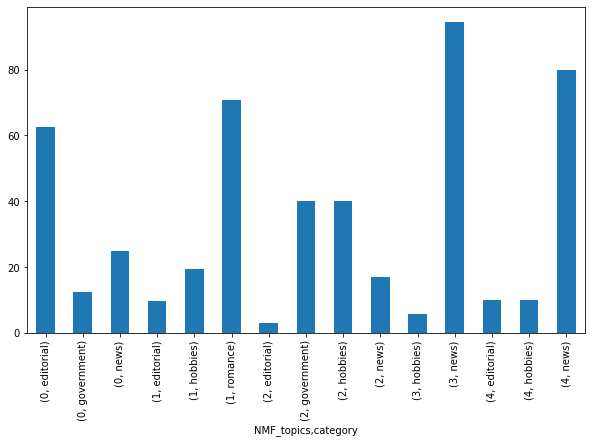

In [16]:
# Your code here

grp_df.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).plot.bar(figsize=(10,6))

# Section Complete

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF model is able to clearly separate and map 4 out of 5 of the original topics (topic00 - editorial, topic01 - romance, topic02 - government, topic03 - news), but it doesn't have clear mapping ability between topic04 and hobbies. The NMF model results can be seen above in the NMF topics / category graph.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

In [17]:
# Your code here

svd_para_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

# Section Complete

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
svd_para_model.singular_values_

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([3.70145447, 2.25514643, 1.69735202, 1.66198175, 1.55995291])

In [19]:
df['LSA_topics'] = pd.DataFrame(W_svd_para_matrix).idxmax(axis=1)
grp_df = df.groupby(['LSA_topics','category'])['id'].count()
grp_df.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LSA_topics  category  
0           editorial      18.243243
            government     20.270270
            hobbies        24.324324
            news           22.972973
            romance        14.189189
1           romance       100.000000
3           news          100.000000
4           news          100.000000
Name: id, dtype: float64

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model is able to identify the Romance category (topic 1) which aligns with our output of the NMF model. As you'll see in the displayed topics below. 

In [20]:
# call display_topics on your model

display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names())

# Section Complete


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What is your interpretation of the display topics output? 

A: It is interesting to look at the displayed topics in particular Topic 03. The top 5 terms returned have an interesting connection with a location, game, club, and Mrs. I wonder what reference this could be connecting back to.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [21]:
# Fit your LDA model here

lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

# Section Complete

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Call `display_topics` on your fitted model here

display_topics(lda_para_model, count_text_vectorizer.get_feature_names())

# Section Complete


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
df['LDA_topics'] = pd.DataFrame(W_lda_para_matrix).idxmax(axis=1)
grp_df = df.groupby(['LDA_topics','category'])['id'].count()
grp_df.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA_topics  category  
0           editorial     10.714286
            hobbies       57.142857
            news          32.142857
1           editorial      2.631579
            government    52.631579
            hobbies       36.842105
            news           7.894737
2           editorial     39.285714
            government     3.571429
            hobbies        1.785714
            news          55.357143
3           government    66.666667
            hobbies       25.000000
            news           8.333333
4           editorial      3.125000
            hobbies        6.250000
            romance       90.625000
Name: id, dtype: float64

Q: What inference do you draw from the displayed topics for your LDA model? 

A: I found it interesting looking at the terms displayed in topic 01. It correctly identified government and the terms associated with it are terms you would likely expect from that topic. The terms such as state(s), development, and program seem like terms you could reasonably expect to hear in a Government topic. 


Q: How does your five-topic LDA model compare to the original Brown categories? 

A: It seems that topic 04 does a decently well job categorizing romance with the LDA model. It has similar performance as my first model above when it comes to a few topics, but it does not perform as well as the other.  

In [26]:
lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\jackt\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [27]:
pyLDAvis.display(lda_display)

C:\Users\jackt\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: I'll try to best explain these graphs through my interpretation. It looks like topics 2-4 seem to be reasonably connected intertopic distance map. 1 and 5 seem hardly related, while 1 also seems to be the opposite of topics 2-4. Term frequencies such as united, department, states, and business seem to be prevalent within topics 2-4. Said is largely associated with topics 3 and 5. When you highlight each topic you can see the distribution of each term within that topic.
